# exp032

In [1]:
MODE = 'local_train'
#MODE = 'kaggle_inference'

In [2]:
exp_name = 'exp032'
memo = 'exp030 dist10+tfidf_name_sim10の1st'

In [3]:
import os
import sys
import gc

if MODE == 'local_train':
    sys.path.append('/home/kaggler/.local/lib/python3.8/site-packages')
    from dotenv import load_dotenv
    load_dotenv
    sys.path.append(os.getenv('UTILS_PATH'))
    import line_notify
    import slack_notify
    
if MODE == "kaggle_inference":
    from cuml import ForestInference
    import treelite
    
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt; plt.style.use("ggplot")
import seaborn as sns
from sklearn.metrics.pairwise import haversine_distances
from sklearn.model_selection import GroupKFold, KFold, StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.decomposition import TruncatedSVD
import lightgbm as lgb
import itertools
from scipy.spatial.distance import canberra
from sklearn.neighbors import KNeighborsRegressor
import functools
import multiprocessing
import Levenshtein
import difflib
import pickle
from tqdm import tqdm
%load_ext Cython

from transformers import DistilBertModel, DistilBertTokenizer
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
import torch.nn as nn
import torch

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

from cuml.feature_extraction.text import TfidfVectorizer as TfidfVectorizer_gpu
import cudf, cuml, cupy
from cuml.neighbors import NearestNeighbors as NearestNeighbors_gpu

In [4]:
# directry_setting
if MODE == 'local_train':
    INPUT_DIR = os.getenv('INPUT_DIR')
    OUTPUT_DIR = os.getenv('OUTPUT_DIR')
    MODEL_DIR = os.getenv('OUTPUT_DIR')
    BERT_MODEL = "distilbert-base-multilingual-cased"
    os.makedirs(OUTPUT_DIR + exp_name, exist_ok=True)

elif MODE == 'kaggle_inference':
    INPUT_DIR = '/kaggle/input/foursquare-location-matching/'
    OUTPUT_DIR = './'
    MODEL_DIR = f'../input/fs{exp_name}/'
    BERT_MODEL = "../input/distilbertbaseuncased"

In [5]:
# CONFIG
SEED = 42
N_NEIGHBORS = 10
N_SPLITS = 5
PROB_TH = 0.5
MAX_LEN = 32
BS = 512
NW = 2
SVD_N_COMP = 50

In [6]:
class Cat2VecModel(nn.Module):
    def __init__(self):
        super(Cat2VecModel, self).__init__()
        self.distill_bert = DistilBertModel.from_pretrained(BERT_MODEL)
        
    def forward(self, ids, mask):
        x = self.distill_bert(ids, mask)[0]
        x = F.normalize((x[:, 1:, :]*mask[:, 1:, None]).mean(axis=1))
        return x

class InferenceDataset(Dataset):
    
    def __init__(self, df, max_len, col):
        super().__init__()
        self.df = df.reset_index(drop=True)
        self.max_len = max_len
        self.tokenizer = DistilBertTokenizer.from_pretrained(BERT_MODEL, do_lower_case=True)
        self.col = col

    def __getitem__(self, index):
        row = self.df.iloc[index]
        
        inputs = self.tokenizer.encode_plus(
            row[self.col],
            None,
            add_special_tokens=True,
            max_length=MAX_LEN,
            padding="max_length",
            return_token_type_ids=True,
            truncation=True
        )
        ids = torch.LongTensor(inputs['input_ids'])
        mask = torch.LongTensor(inputs['attention_mask'])

        return ids, mask

    def __len__(self):
        return self.df.shape[0]

def inference(ds):
    cat2vec_model = Cat2VecModel()
    cat2vec_model = cat2vec_model.cuda()
    
    loader = DataLoader(ds, batch_size=BS, shuffle=False, num_workers=NW,
                        pin_memory=False, drop_last=False)
    
    vs = []
    with torch.no_grad():
        for idx, (ids, masks) in enumerate(loader):
            v = cat2vec_model(ids.cuda(), masks.cuda()).detach().cpu().numpy()
            vs.append(v)
    return np.concatenate(vs)

In [7]:
def make_bert_vec(df, col):
    cat_df = df[[col]].drop_duplicates()
    cat_df[col] = cat_df[col].fillna("null")

    cat_ds = InferenceDataset(cat_df, max_len=MAX_LEN, col=col)
    V = inference(cat_ds)
    #svd = TruncatedSVD(n_components=SVD_N_COMP, random_state=SEED)
    #V = svd.fit_transform(V)
    V = V.astype("float16")
    bert_vec = {k:v for k,v in zip(cat_df[col].values, V)}
    return bert_vec

In [8]:
def preprocess(df):
    columns = ['id', 'name', 'address', 'city', 'state',
        'zip', 'country', 'url', 'phone', 'categories']
    for c in columns:
        if c != "id":
            df[c] = df[c].astype(str).str.lower()

    df[["latitude", "longitude"]] = np.deg2rad(df[["latitude", "longitude"]])
    
    return df

In [9]:
def extract_candidate_dist(df):
    dfs = []
    for country, country_df in tqdm(df.groupby("country")):
        country_df = country_df.reset_index(drop=True)
        
        knn = KNeighborsRegressor(n_neighbors=min(len(country_df), N_NEIGHBORS), 
                                    metric='haversine', n_jobs=-1)
        knn.fit(country_df[['latitude','longitude']], country_df.index)
        nears = knn.kneighbors(country_df[['latitude','longitude']], return_distance=False)
        
        k = min(len(country_df), N_NEIGHBORS)
        country_df['match_id'] = country_df['id'].values[nears[:, :k]].tolist()
        country_df = country_df.explode(['match_id'])
        country_df = country_df.loc[country_df['id'] != country_df['match_id']].copy()
        dfs.append(country_df)
    df = pd.concat(dfs).reset_index(drop=True)
    return df

In [10]:
def extract_candidate_tfidf_sim(df, col):
    dfs = []
    for country, country_df in tqdm(df.groupby("country")):
        country_df = country_df[country_df[col]!="nan"].copy()
        if len(country_df) < 2:
            continue

        country_df = country_df.reset_index(drop=True)
        
        model = TfidfVectorizer_gpu(stop_words='english', binary=True)
        text_embeddings = model.fit_transform(cudf.from_pandas(country_df[col]))

        model = NearestNeighbors_gpu(n_neighbors=min(len(country_df), N_NEIGHBORS), algorithm="brute")
        model.fit(text_embeddings)
        nears = model.kneighbors(text_embeddings, return_distance=False)
        
        k = min(len(country_df), N_NEIGHBORS)
        country_df['match_id'] = country_df['id'].values[nears[:, :k].get()].tolist()
        country_df = country_df.explode(['match_id'])
        country_df = country_df.loc[country_df['id'] != country_df['match_id']].copy()
        dfs.append(country_df)
    df = pd.concat(dfs).reset_index(drop=True)
    return df

In [11]:
def add_orgin_data(df, org_df):
    df = df.merge(org_df.add_prefix('match_'), on='match_id')
    df = df.reset_index(drop=True)
    return df

In [12]:
def haversine_np(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length.    

    """
    #lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    return c

In [13]:
# https://www.kaggle.com/code/columbia2131/foursquare-iou-metrics
def get_id2poi(input_df: pd.DataFrame) -> dict:
    return dict(zip(input_df['id'], input_df['point_of_interest']))

def get_poi2ids(input_df: pd.DataFrame) -> dict:
    return input_df.groupby('point_of_interest')['id'].apply(set).to_dict()

def get_score(input_df: pd.DataFrame, org_data):
    scores = []
    id2poi = get_id2poi(org_data)
    poi2ids = get_poi2ids(org_data)
    for id_str, matches in zip(input_df['id'].to_numpy(), input_df['matches'].to_numpy()):
        targets = poi2ids[id2poi[id_str]]
        preds = set(matches.split())
        score = len((targets & preds)) / len((targets | preds))
        scores.append(score)
    scores = np.array(scores)
    return scores.mean()

def calc_max_score(tr_data, org_data):
    train_candidate = pd.DataFrame()
    train_candidate['id'] = org_data['id'].unique()
    train_candidate['matches'] = org_data['id'].unique()
    idx = tr_data['point_of_interest']==tr_data['match_point_of_interest']
    train_match = tr_data.loc[idx].groupby('id')['match_id'].apply(list).map(" ".join).reset_index()
    train_match.columns = ['id','candidates']
    train_candidate = train_candidate.merge(train_match, on = 'id', how = 'left')
    idx = ~train_candidate['candidates'].isna()
    train_candidate.loc[idx, "matches"] += " " + train_candidate.loc[idx, "candidates"]
    score = get_score(train_candidate, org_data)
    print('1st_stage_max_score : ' + '{:.5f}'.format(score))
    return score

In [14]:
def categorical_similarity(A, B):
    if not A or not B:
        return -1

    A = set(str(A).split(", "))
    B = set(str(B).split(", "))

    # Find intersection of two sets
    nominator = A.intersection(B)

    similarity_1 = len(nominator) / len(A)
    similarity_2 = len(nominator) / len(B)

    return max(similarity_1, similarity_2)

In [15]:
%%cython
def LCS(str S, str T):
    cdef int i, j
    cdef list dp = [[0] * (len(T) + 1) for _ in range(len(S) + 1)]
    for i in range(len(S)):
        for j in range(len(T)):
            dp[i + 1][j + 1] = max(dp[i][j] + (S[i] == T[j]), dp[i + 1][j], dp[i][j + 1], dp[i + 1][j + 1])
    return dp[len(S)][len(T)]

In [16]:
def make_tfidf_vec(df, col):
    df_ = pd.concat([df[col], df["match_" + col]]).drop_duplicates().to_frame()
    df_ = df_.reset_index(drop=True)
    df_.columns = [col]

    tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2), stop_words='english')
    tfidf_vec = tfidf_vectorizer.fit_transform(df_[col].tolist())
    tfidf_vec = {k:v for k,v in zip(df_[col].values, tfidf_vec)}
    return tfidf_vec

In [17]:
def _add_distance_features(args):
    _, df = args

    columns = ['name', 'address', 'city', 'state',
               'zip', 'url', 'phone', 'categories']

    for c in columns:
        geshs = []
        levens = []
        jaros = []
        lcss = []
        tfidf_sims = []

        if c in ["name", "categories"]:
            tfidf_vec = make_tfidf_vec(df, c)


        for str1, str2 in df[[f"{c}", f"match_{c}"]].values.astype(str):
            if str1 != "nan" and str2 != "nan":
                geshs.append(difflib.SequenceMatcher(None, str1, str2).ratio())
                levens.append(Levenshtein.distance(str1, str2))
                jaros.append(Levenshtein.jaro_winkler(str1, str2))
                lcss.append(LCS(str(str1), str(str2)))

                if c in ["name", "categories"]:
                    sim = cosine_similarity(tfidf_vec[str1].reshape(1, -1), tfidf_vec[str2].reshape(1, -1))[0][0]
                    tfidf_sims.append(sim)

            else:
                geshs.append(-1)
                levens.append(-1)
                jaros.append(-1)
                lcss.append(-1)
                
                if c in ["name", "categories"]:
                    tfidf_sims.append(-1)


        df[f"match_{c}_gesh"] = geshs
        df[f"match_{c}_gesh"] = df[f"match_{c}_gesh"].astype(np.float16)
        df[f"match_{c}_leven"] = levens
        df[f"match_{c}_leven"] = df[f"match_{c}_leven"].astype(np.float16)
        df[f"match_{c}_jaro"] = jaros
        df[f"match_{c}_jaro"] = df[f"match_{c}_jaro"].astype(np.float16)
        df[f"match_{c}_lcs"] = lcss
        df[f"match_{c}_lcs"] = df[f"match_{c}_lcs"].astype(np.float16)
            
        if not c in ['country', "phone", "zip"]:
            df[f"match_{c}_len"] = df[f"match_{c}"].astype(str).map(len)
            df[f"{c}_len"] = df[f"{c}"].astype(str).map(len)
            df[f"match_{c}_nleven"] = df[f"match_{c}_leven"] / df[[f"match_{c}_len", f"{c}_len"]].max(axis=1)
            df[f"match_{c}_nleven"] = df[f"match_{c}_nleven"].astype(np.float16)
            df[f"match_{c}_nlcsi"] = df[f"match_{c}_lcs"] / df[f"match_{c}_len"]
            df[f"match_{c}_nlcs0"] = df[f"match_{c}_lcs"] / df[f"{c}_len"]
            df[f"match_{c}_nlcsi"] = df[f"match_{c}_nlcsi"].astype(np.float16)
            df[f"match_{c}_nlcs0"] = df[f"match_{c}_nlcs0"].astype(np.float16)
            df.drop(f'{c}_len',axis=1, inplace = True)
            df.drop(f"match_{c}_len",axis=1, inplace = True)

        if c in ["name", "categories"]:
            df[f"tfidf_sim_{c}"] = tfidf_sims
            df[f"tfidf_sim_{c}"] = df[f"tfidf_sim_{c}"].astype(np.float16)

    return df


def add_distance_features(df):
    processes = multiprocessing.cpu_count()
    with multiprocessing.Pool(processes=processes) as pool:
        dfs = pool.imap_unordered(_add_distance_features, df.groupby('country'))
        dfs = tqdm(dfs)
        dfs = list(dfs)
    df = pd.concat(dfs)
    return df

In [18]:
def add_vec_sim_features(df, vec, vec_name, col):
    sim_list = []
    for str1, str2 in tqdm(df[[f"{col}", f"match_{col}"]].values.astype(str)):
        if str1!="nan" and str2!="nan":
            sim = cosine_similarity(vec[str1].reshape(1, -1), vec[str2].reshape(1, -1))[0][0]
        else:
            sim = -1
        sim_list.append(sim)
    df[f"{vec_name}_sim_{col}"] = sim_list
    df[f"{vec_name}_sim_{col}"] = df[f"{vec_name}_sim_{col}"].astype(np.float16)
    return df

In [19]:
def reduce_data_size(df, features):
    if MODE == 'local_train':
        df = df[features + ['target', 'id', 'match_id']].copy()
    elif MODE == 'kaggle_inference':
        df = df[features + ['id', 'match_id']].copy()


    df[features] = df[features].astype(np.float16)
    for _ in range(5):
        gc.collect()
        
    return df

In [20]:
def train_model(df, features):
    params = {'objective': 'binary', 
              'boosting': 'gbdt',
              'learning_rate': 0.1, 
              'metric': 'binary_logloss', 
              'seed': SEED, 
              'feature_pre_filter': False, 
              'lambda_l1': 0.5745709668124809, 
              'lambda_l2': 0.5123383865042099, 
              'num_leaves': 239, 
              'feature_fraction': 0.784, 
              'bagging_fraction': 1.0, 
              'bagging_freq': 0, 
              'min_child_samples': 5
              }

    # split folds
    kf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)
    for i, (trn_idx, val_idx) in enumerate(kf.split(df, df["target"], df["target"])):
        df.loc[val_idx, "fold"] = i
    
    fi = pd.DataFrame()
    oof = df[['id', 'match_id', 'target']].copy()
    oof['prob'] = 0.0
    scores = []

    for i in range(N_SPLITS):
        print('fold : ' + str(i))
        tr_idx = df[df['fold'] != i].index
        vl_idx = df[df['fold'] == i].index
        tr_x, tr_y = df.loc[tr_idx, features], df.loc[tr_idx, 'target']
        vl_x, vl_y = df.loc[vl_idx, features], df.loc[vl_idx, 'target']
        tr_data = lgb.Dataset(tr_x, label=tr_y)
        vl_data = lgb.Dataset(vl_x, label=vl_y)

        model = lgb.train(params, tr_data, valid_sets=[tr_data, vl_data],
                        num_boost_round=20000, early_stopping_rounds=100, verbose_eval=1000)

        # 特徴量重要度
        fi_tmp = pd.DataFrame()
        fi_tmp['feature'] = model.feature_name()
        fi_tmp['importance'] = model.feature_importance(importance_type='gain')
        fi_tmp['iter'] = i
        fi = fi.append(fi_tmp)

        pred = model.predict(vl_x, num_iteration=model.best_iteration)
        oof.loc[vl_idx, 'prob'] = pred

        score = accuracy_score((pred > PROB_TH).astype(int), vl_y)
        scores.append(score)
        print(f'fold{i} | accuracy = ' + '{:.5f}'.format(score))

        with open(OUTPUT_DIR + f'{exp_name}/model{i}.pickle', 'wb') as f:
            pickle.dump(model, f)
        
    oof.to_csv(OUTPUT_DIR + f'{exp_name}/{exp_name}_oof.csv', index=False)

    print('accuracy(mean) : ' + '{:.5f}'.format(np.mean(scores)))
    print(scores)

    fi_n = fi['feature'].nunique()
    order = list(fi.groupby("feature").mean().sort_values("importance", ascending=False).index)
    plt.figure(figsize=(10, fi_n*0.2))
    sns.barplot(x="importance", y="feature", data=fi, order=order)
    plt.title(f"LGBM importance")
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR + f'{exp_name}/lgbm_importance.png')

    return oof, np.mean(scores)

In [21]:
def model_inference(df, features):
    pred = np.zeros(len(df))
    for i in range(N_SPLITS):
        with open(MODEL_DIR + f'model{i}.pickle', 'rb') as f:
            model = pickle.load(f)
        model.save_model("test.lgb")
        fi = ForestInference()
        fi = ForestInference.load("test.lgb", output_class=True, model_type="lightgbm")
        pred += fi.predict(df[features]) / N_SPLITS
    return pred

In [22]:
def transform_data(df, org_data):
    train_candidate = pd.DataFrame()
    train_candidate['id'] = org_data['id'].unique()
    train_candidate['matches'] = org_data['id'].unique()

    train_match = df[df['prob'] >= PROB_TH].copy()
    train_match = train_match.groupby('id')['match_id'].apply(list).map(" ".join).reset_index()
    train_match.columns = ['id','candidates']
    train_candidate = train_candidate.merge(train_match, on = 'id', how = 'left')
    idx = ~train_candidate['candidates'].isna()
    train_candidate.loc[idx, "matches"] += " " + train_candidate.loc[idx, "candidates"]
    return train_candidate[['id', 'matches']]


In [23]:
def postprocess(df):
    id2match = dict(zip(df["id"].values, df["matches"].str.split()))

    for match in tqdm(df["matches"]):
        match = match.split()
        if len(match) == 1:        
            continue

        base = match[0]
        for m in match[1:]:
            if not base in id2match[m]:
                id2match[m].append(base)
    df["matches"] = df["id"].map(id2match).map(" ".join)
    return df 

In [24]:
def run_train():
    train_origin = pd.read_csv(INPUT_DIR + "train.csv")
    train_origin = preprocess(train_origin)

    # trainデータの分割
    kf = GroupKFold(n_splits=2)
    for i, (trn_idx, val_idx) in enumerate(kf.split(train_origin, train_origin['point_of_interest'], train_origin['point_of_interest'])):
        train_origin.loc[val_idx, "set"] = i

    # 1st stage
    train = pd.concat([
        extract_candidate_dist(train_origin[train_origin["set"]==0]), 
        extract_candidate_dist(train_origin[train_origin["set"]==1]),
        extract_candidate_tfidf_sim(train_origin[train_origin["set"]==0], "name"), 
        extract_candidate_tfidf_sim(train_origin[train_origin["set"]==1], "name")
    ])
    train = train.drop_duplicates(subset=["id", "match_id"])
    train = add_orgin_data(train, train_origin)
    stage1_max_score = calc_max_score(train, train_origin)

    # 2nd stage
    train["habersine_dist"] = haversine_np(train["longitude"], train["latitude"], train["match_longitude"], train["match_latitude"])
    # create target
    train['target'] = (train['point_of_interest'] == train['match_point_of_interest']).values.astype(int)
    train["target"] = train["target"].fillna(0)

    train = add_distance_features(train)
    train["category_venn"] = train[["categories", "match_categories"]].apply(lambda row: categorical_similarity(row.categories, row.match_categories), axis=1)
    
    # reduce memory
    train = train.drop(columns=['latitude', 'longitude', 'address', 'city', 'state', 'zip', 'country', 'url', 'phone',
                                'match_latitude', 'match_longitude', 'match_address', 'match_city', 'match_state', 
                                'match_zip', 'match_country', 'match_url', 'match_phone'])
    gc.collect()

    # bert類似度
    bert_vec_categories = make_bert_vec(train_origin[["categories"]], "categories")
    train = add_vec_sim_features(train, bert_vec_categories, "bert", "categories")
    del bert_vec_categories
    gc.collect()

    print("add_bert_sim_name")
    bert_vec_name = make_bert_vec(train_origin[["name"]], "name")
    train = add_vec_sim_features(train, bert_vec_name, "bert", "name")
    del bert_vec_name
    gc.collect()


    not_use_cols = ['match_state_leven', 'address', 'categories', 'point_of_interest', 'match_address_leven',
                    'city', 'match_point_of_interest', 'match_name', 'match_categories_leven', 'match_longitude',
                    'target', 'match_city_leven', 'zip', 'match_categories', 'match_city', 'match_latitude',
                    'match_zip', 'match_url', 'id', 'match_set', 'country', 'match_state', 'match_address',
                    'match_name_leven', 'match_id', 'latitude', 'url', 'set', 'name', 'phone', 'longitude',
                    'match_url_leven', 'state', 'match_phone', 'match_country']
    features = [c for c in train.columns if c not in not_use_cols]
    with open(OUTPUT_DIR + f'{exp_name}/features.pickle', 'wb') as f:
        pickle.dump(features, f)

    train = reduce_data_size(train, features)

    oof, stage2_mean_accuracy = train_model(train, features)
    oof = transform_data(oof, train_origin)

    cv_score = get_score(oof, train_origin)
    print(f'cv_score = ' + '{:.5f}'.format(cv_score))

    oof = postprocess(oof)
    cv_score_after_pp = get_score(oof, train_origin)
    print(f'cv_score(after_pp) = ' + '{:.5f}'.format(cv_score_after_pp))


    report = f'{exp_name}\n'
    report += memo + '\n'
    report += 'stage1_max_score : ' + '{:.5f}'.format(stage1_max_score) + '\n'
    report += 'stage2_mean_accuracy : ' + '{:.5f}'.format(stage2_mean_accuracy) + '\n'
    report += 'cv_score : ' + '{:.5f}'.format(cv_score) + '\n'
    report += 'cv_score_after_pp : ' + '{:.5f}'.format(cv_score_after_pp) + '\n'
    print(report)
    line_notify.send(report)
    slack_notify.send(report)

In [25]:
def run_inference():
    test_origin = pd.read_csv(INPUT_DIR + "test.csv")
    sub = pd.read_csv(INPUT_DIR + "sample_submission.csv", usecols=["id"])

    if len(test_origin) == 5:
        test_origin = pd.read_csv(INPUT_DIR + "train.csv")
        kf = GroupKFold(n_splits=100)
        for i, (trn_idx, val_idx) in enumerate(kf.split(test_origin, test_origin['point_of_interest'], test_origin['point_of_interest'])):
            test_origin = test_origin.loc[val_idx]
            test_origin = test_origin.reset_index(drop=True)
            sub = test_origin[["id"]].copy()
            break
    
    test_origin = preprocess(test_origin)
    
    kf = GroupKFold(n_splits=5)
    for i, (trn_idx, val_idx) in enumerate(kf.split(test_origin, test_origin['country'].fillna(""), test_origin['country'].fillna(""))):
        test_origin.loc[val_idx, "c_fold"] = int(i)

    country_tests = []
    for c_fold in test_origin["c_fold"].unique():
        test_origin_batch = test_origin[test_origin["c_fold"]==c_fold].copy()
        test_origin_batch = test_origin_batch.reset_index(drop=True)
        test_origin_batch =test_origin_batch.drop(columns=["c_fold"])

        # 1st stage
        test = pd.concat([extract_candidate_dist(test_origin_batch),
                          extract_candidate_tfidf_sim(test_origin_batch, "name")
        ])
        test = test.drop_duplicates(subset=["id", "match_id"])

        # 2nd stage
        print("add_org")
        test = add_orgin_data(test, test_origin_batch)
        
        print("add_dist_feat")
        test["habersine_dist"] = haversine_np(test["longitude"], test["latitude"], test["match_longitude"], test["match_latitude"])
        test = add_distance_features(test)
        test["category_venn"] = test[["categories", "match_categories"]].apply(lambda row: categorical_similarity(row.categories, row.match_categories), axis=1)

        # reduce memory
        test = test.drop(columns=['latitude', 'longitude', 'address', 'city', 'state', 'zip', 'country', 'url', 'phone',
                                    'match_latitude', 'match_longitude', 'match_address', 'match_city', 'match_state', 
                                    'match_zip', 'match_country', 'match_url', 'match_phone'])
        gc.collect()


        # bert類似度
        bert_vec_categories = make_bert_vec(test_origin_batch[["categories"]], "categories")
        test = add_vec_sim_features(test, bert_vec_categories, "bert", "categories")
        del bert_vec_categories
        gc.collect()
        bert_vec_name = make_bert_vec(test_origin_batch[["name"]], "name")
        test = add_vec_sim_features(test, bert_vec_name, "bert", "name")
        del bert_vec_name
        gc.collect()
        
        with open(MODEL_DIR + 'features.pickle', 'rb') as f:
            features = pickle.load(f)
        test = reduce_data_size(test, features)

        print('test_dataset_info')
        print(test.info())

        test['prob'] = model_inference(test, features)
        test = transform_data(test, test_origin_batch)
        country_tests.append(test)

        del test, test_origin_batch
        gc.collect()

    test = pd.concat(country_tests)
    test = postprocess(test)

    sub = sub.merge(test, on="id", how="left") 
    sub.to_csv('submission.csv', index=False)

100%|██████████| 211/211 [00:41<00:00,  5.07it/s]


1st_stage_max_score : 0.94800


213it [1:26:11, 24.28s/it]  
Some weights of the model checkpoint at distilbert-base-multilingual-cased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 20021905/20021905 [35:25<00:00, 9421.55it/s] 


add_bert_sim_name


Some weights of the model checkpoint at distilbert-base-multilingual-cased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 20021905/20021905 [41:19<00:00, 8073.71it/s]


fold : 0


/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 804467, number of negative: 15213057
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.251639 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9146
[LightGBM] [Info] Number of data points in the train set: 16017524, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.050224 -> initscore=-2.939729
[LightGBM] [Info] Start training from score -2.939729
Training until validation scores don't improve for 100 rounds
[1000]	training's binary_logloss: 0.0398118	valid_1's binary_logloss: 0.0474471
[2000]	training's binary_logloss: 0.0314817	valid_1's binary_logloss: 0.0431625
[3000]	training's binary_logloss: 0.0255988	valid_1's binary_logloss: 0.0400591
[4000]	training's binary_logloss: 0.0210589	valid_1's binary_logloss: 0.0375562
[5000]	training's binary_logloss: 0.0175732	valid_1's binary_logloss: 0.0355774
[6000]	training's binary_logloss: 

/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 804756, number of negative: 15212768
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.219470 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9114
[LightGBM] [Info] Number of data points in the train set: 16017524, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.050242 -> initscore=-2.939351
[LightGBM] [Info] Start training from score -2.939351
Training until validation scores don't improve for 100 rounds
[1000]	training's binary_logloss: 0.0399759	valid_1's binary_logloss: 0.0474815
[2000]	training's binary_logloss: 0.0315181	valid_1's binary_logloss: 0.0430546
[3000]	training's binary_logloss: 0.0255919	valid_1's binary_logloss: 0.0398693
[4000]	training's binary_logloss: 0.0211858	valid_1's binary_logloss: 0.0374191
[5000]	training's binary_logloss: 0.0177253	valid_1's binary_logloss: 0.0354251
[6000]	training's binary_logloss: 

/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 803781, number of negative: 15213743
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.216279 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9161
[LightGBM] [Info] Number of data points in the train set: 16017524, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.050181 -> initscore=-2.940628
[LightGBM] [Info] Start training from score -2.940628
Training until validation scores don't improve for 100 rounds
[1000]	training's binary_logloss: 0.0397313	valid_1's binary_logloss: 0.0471085
[2000]	training's binary_logloss: 0.0312851	valid_1's binary_logloss: 0.0427779
[3000]	training's binary_logloss: 0.0256152	valid_1's binary_logloss: 0.0397634
[4000]	training's binary_logloss: 0.0212663	valid_1's binary_logloss: 0.0373544
[5000]	training's binary_logloss: 0.0178075	valid_1's binary_logloss: 0.0354177
[6000]	training's binary_logloss: 

/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 804316, number of negative: 15213208
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.239087 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9117
[LightGBM] [Info] Number of data points in the train set: 16017524, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.050215 -> initscore=-2.939927
[LightGBM] [Info] Start training from score -2.939927
Training until validation scores don't improve for 100 rounds
[1000]	training's binary_logloss: 0.0398029	valid_1's binary_logloss: 0.0474144
[2000]	training's binary_logloss: 0.0315089	valid_1's binary_logloss: 0.0431544
[3000]	training's binary_logloss: 0.0256868	valid_1's binary_logloss: 0.0400374
[4000]	training's binary_logloss: 0.0212627	valid_1's binary_logloss: 0.037597
[5000]	training's binary_logloss: 0.0177509	valid_1's binary_logloss: 0.035608
[6000]	training's binary_logloss: 0.

/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 804268, number of negative: 15213256
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.220161 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9156
[LightGBM] [Info] Number of data points in the train set: 16017524, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.050212 -> initscore=-2.939990
[LightGBM] [Info] Start training from score -2.939990
Training until validation scores don't improve for 100 rounds
[1000]	training's binary_logloss: 0.0398437	valid_1's binary_logloss: 0.0473731
[2000]	training's binary_logloss: 0.0315008	valid_1's binary_logloss: 0.043127
[3000]	training's binary_logloss: 0.0257144	valid_1's binary_logloss: 0.0399941
[4000]	training's binary_logloss: 0.021299	valid_1's binary_logloss: 0.0375931
[5000]	training's binary_logloss: 0.0176804	valid_1's binary_logloss: 0.0355282
[6000]	training's binary_logloss: 0.

100%|██████████| 1138812/1138812 [00:01<00:00, 895572.56it/s]


cv_score(after_pp) = 0.91051
exp032
exp030 dist10+tfidf_name_sim10の1st
stage1_max_score : 0.94800
stage2_mean_accuracy : 0.99141
cv_score : 0.90613
cv_score_after_pp : 0.91051



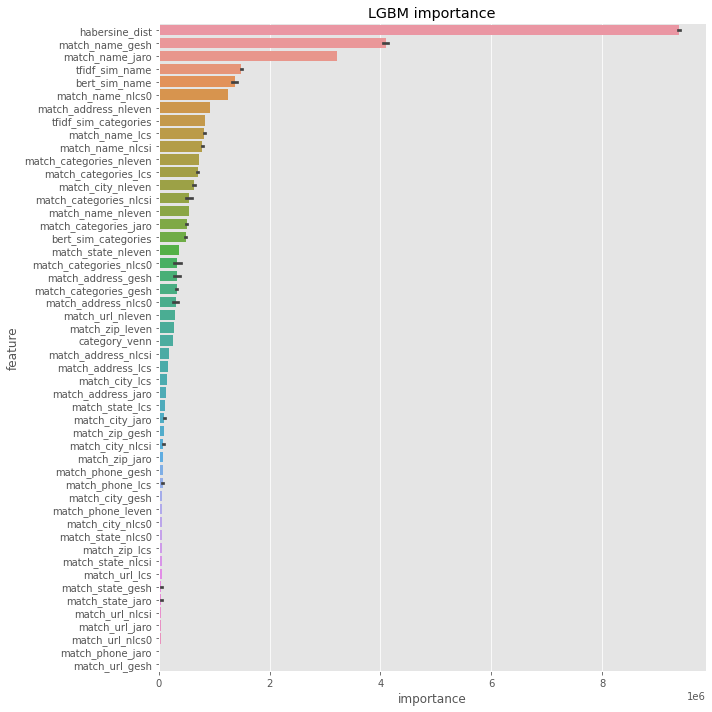

In [26]:
if MODE == 'local_train':
    run_train()
elif MODE == 'kaggle_inference':
    run_inference()